In [1]:
import itertools
import os
import os.path as osp
import pickle
import urllib
from collections import namedtuple

import numpy as np
import scipy.sparse as sp
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.nn import Linear 

from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics.cluster import normalized_mutual_info_score

import pandas as pd
%matplotlib inline

In [2]:
def tensor_from_numpy(x, device):
    return torch.from_numpy(x).to(device)

In [3]:
class GraphConvolution(nn.Module):
    def __init__(self, input_dim, output_dim, use_bias=True):
        """图卷积：L*X*\theta

        Args:
        ----------
            input_dim: int
                节点输入特征的维度
            output_dim: int
                输出特征维度
            use_bias : bool, optional
                是否使用偏置
        """
        super(GraphConvolution, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.use_bias = use_bias
        self.weight = nn.Parameter(torch.Tensor(input_dim, output_dim))
        if self.use_bias:
            self.bias = nn.Parameter(torch.Tensor(output_dim))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        init.kaiming_uniform_(self.weight)
        if self.use_bias:
            init.zeros_(self.bias)

    def forward(self, adjacency, input_feature):
        """邻接矩阵是稀疏矩阵，因此在计算时使用稀疏矩阵乘法
    
        Args: 
        -------
            adjacency: torch.sparse.FloatTensor
                邻接矩阵
            input_feature: torch.Tensor
                输入特征
        """
        support = torch.mm(input_feature, self.weight)
        output = torch.sparse.mm(adjacency, support)
        if self.use_bias:
            output += self.bias
        return output

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
            + str(self.input_dim) + ' -> ' \
            + str(self.output_dim) + ')'

In [4]:
class GcnNet(nn.Module):
    """
    定义一个 GraphConvolution的模型
    """
    def __init__(self, input_dim=1433):
        super(GcnNet, self).__init__()
        self.gcn1 = GraphConvolution(input_dim, 60)
        self.gcn2 = GraphConvolution(60,36)
        self.gcn3 = GraphConvolution(36,12 )
#         self.gcn4 = GraphConvolution(24, 12)
#         self.gcn5 = GraphConvolution(36, 12)
#         self.gcn6 = GraphConvolution(150, 400)
#         self.gcn7 = GraphConvolution(400, 940)
#         self.gcn8 = GraphConvolution(940, input_dim)
        
        self.h1=None
        self.h2=None
        self.h3=None
        self.h4=None
        self.h5=None
        self.h6=None
        self.h7=None
        self.h8=None
    
    def forward(self, adjacency, feature):
        self.h1 = F.relu(self.gcn1(adjacency, feature))
        self.h1 = F.normalize(self.h1)
        
        self.h2  = F.sigmoid(self.gcn2(adjacency, self.h1))
        self.h2 = F.normalize(self.h2)
        
        self.h3 = self.gcn3(adjacency, self.h2) 
        
#         self.h3 = F.relu(self.gcn3(adjacency, self.h2))
#         self.h3 = F.normalize(self.h3)
        
#         self.h4  = F.sigmoid(self.gcn4(adjacency, self.h3))
#         self.h4 = F.normalize(self.h4)
        
#         self.h5  =  self.gcn5(adjacency, self.h4) 
        
#         self.h5  = F.relu(self.gcn5(adjacency, self.h4))
#         self.h5 = F.normalize(self.h5)
        
#         self.h6  = F.sigmoid(self.gcn6(adjacency, self.h5))
#         self.h6 = F.normalize(self.h6)
        
#         self.h7  = F.relu(self.gcn7(adjacency, self.h6))
#         self.h7 = F.normalize(self.h7)
        
#         self.h8  = self.gcn8(adjacency, self.h7)
 
        return  self.h3



In [5]:
# 超参数定义
LEARNING_RATE = 0.01
WEIGHT_DACAY = 3e-4
EPOCHS = 20
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


In [6]:
# node_feature = np.load('../data/X_np/X.npy')/ np.load('../data/X_np/X.npy').sum(1, keepdims=True)  

node_feature = np.load('../data/X_np/X.npy')
node_feature2= np.zeros(shape=[850,1879],dtype=np.float32)
node_feature2[:,0:256]=node_feature[:, 0:256]

for i in range(0,850):
    for j in range(0,1623):
        try:
            node_feature2[i][j+256]=max(node_feature[i,256+5*j: 256+j*5+5]) 
        except:
            print(j)
            break
            
node_feature2/=node_feature2.sum(1, keepdims=True)   

node_feature2 = node_feature2.astype(np.float32)
 

tensor_x = tensor_from_numpy(node_feature2, DEVICE)
labelList=pd.read_csv('../data/label.csv',header=None)[1]
for i in range(0,len(labelList)):
    labelList[i]+=1
    

tensor_y = tensor_from_numpy( np.array(labelList,dtype=np.int64),DEVICE)

In [73]:

 
train_mask=[False for i in range(0,850)]
for i in range(0,170):
    train_mask[i]=True
 
val_mask=[False for i in range(0,850)]
for i in range(680,765):
    val_mask[i]=True
    
test_mask=[False for i in range(0,850)]
for i in range(170,850):
    test_mask[i]=True
    
    


tensor_train_mask = tensor_from_numpy(np.array(train_mask), DEVICE )
tensor_val_mask = tensor_from_numpy(np.array(val_mask), DEVICE)
tensor_test_mask = tensor_from_numpy(np.array(test_mask), DEVICE)

# adjacency=np.load('../data/A_np/A.npy')
adjacency=np.load('../data/self_supervised/self_adjacency.npy')

# adjacency=np.eye(850)

        
adjacency=adjacency.astype(np.double)
adjacency = sp.csr_matrix(adjacency)
adjacency = sp.coo_matrix(adjacency)
adjacency += sp.eye(adjacency.shape[0])    # 增加自连接
degree = np.array(adjacency.sum(1))
d_hat = sp.diags(np.power(degree, -0.5).flatten())
normalize_adjacency = d_hat.dot(adjacency).dot(d_hat).tocoo()  # 规范化邻接矩阵

num_nodes, input_dim = tensor_x.shape
 

indices = torch.from_numpy(np.asarray([normalize_adjacency.row, 
                                       normalize_adjacency.col]).astype('int64')).long()
values = torch.from_numpy(normalize_adjacency.data.astype(np.float32))
tensor_adjacency = torch.sparse.FloatTensor(indices, values, 
                                            (num_nodes, num_nodes)).to(DEVICE)

In [74]:
# train_mask

In [75]:
# 模型定义：Model, Loss, Optimizer
model = GcnNet(input_dim).to(DEVICE)
criterion = nn.CrossEntropyLoss().to(DEVICE)
optimizer = optim.Adam(model.parameters(), 
                       lr=LEARNING_RATE, 
                       weight_decay=WEIGHT_DACAY)

In [76]:
# 训练主体函数
def train():
    loss_history = []
    val_acc_history = []
    model.train()
    train_y = tensor_y[tensor_train_mask]
    for epoch in range(EPOCHS):
        # tensor_adjacency 也就是 A 矩阵, tensor_x 也就是 X 矩阵
        logits = model(tensor_adjacency, tensor_x)  # 前向传播
        train_mask_logits = logits[tensor_train_mask]   # 只选择训练节点进行监督
        loss = criterion(train_mask_logits, train_y)    # 计算损失值
        optimizer.zero_grad()
        loss.backward()     # 反向传播计算参数的梯度
        optimizer.step()    # 使用优化方法进行梯度更新
        train_acc, _, _, _ = test(tensor_train_mask)     # 计算当前模型训练集上的准确率
        val_acc, _, _ ,_= test(tensor_val_mask)     # 计算当前模型在验证集上的准确率
        # 记录训练过程中损失值和准确率的变化，用于画图
        loss_history.append(loss.item())
        val_acc_history.append(val_acc.item())
        print("Epoch {:03d}: Loss {:.4f}, TrainAcc {:.4}, ValAcc {:.4f}".format(
            epoch, loss.item(), train_acc.item(), val_acc.item()))
    
    return loss_history, val_acc_history


In [77]:
# 测试函数
def test(mask):
    model.eval()
    with torch.no_grad():
        logits = model(tensor_adjacency, tensor_x)
        test_mask_logits = logits[mask]
        predict_y = test_mask_logits.max(1)[1]# 测试集占 10% 也就是 85个
        accuarcy = torch.eq(predict_y, tensor_y[mask]).float().mean()
    return accuarcy, test_mask_logits.cpu().numpy(), tensor_y[mask].cpu().numpy(),predict_y


In [78]:
def plot_loss_with_acc(loss_history, val_acc_history):
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax1.plot(range(len(loss_history)), loss_history,
             c=np.array([255, 71, 90]) / 255.)
    plt.ylabel('Loss')
    
    ax2 = fig.add_subplot(111, sharex=ax1, frameon=False)
    ax2.plot(range(len(val_acc_history)), val_acc_history,
             c=np.array([79, 179, 255]) / 255.)
    ax2.yaxis.tick_right()
    ax2.yaxis.set_label_position("right")
    plt.ylabel('ValAcc')
    
    plt.xlabel('Epoch')
    plt.title('Training Loss & Validation Accuracy')
    plt.show()


In [85]:
loss, val_acc = train()
test_acc, test_logits, test_label,pre_label = test(tensor_test_mask)
print("Test accuarcy: ", test_acc.item())

Epoch 000: Loss 0.7207, TrainAcc 0.7706, ValAcc 0.7059
Epoch 001: Loss 0.6988, TrainAcc 0.8176, ValAcc 0.7647
Epoch 002: Loss 0.6931, TrainAcc 0.7353, ValAcc 0.6235
Epoch 003: Loss 0.7295, TrainAcc 0.7706, ValAcc 0.7176
Epoch 004: Loss 0.7222, TrainAcc 0.7412, ValAcc 0.6588
Epoch 005: Loss 0.8161, TrainAcc 0.7765, ValAcc 0.7059
Epoch 006: Loss 0.7495, TrainAcc 0.7588, ValAcc 0.7059
Epoch 007: Loss 0.7610, TrainAcc 0.7647, ValAcc 0.7059
Epoch 008: Loss 0.7597, TrainAcc 0.7706, ValAcc 0.7059
Epoch 009: Loss 0.7635, TrainAcc 0.7706, ValAcc 0.7059
Epoch 010: Loss 0.7610, TrainAcc 0.7647, ValAcc 0.6941
Epoch 011: Loss 0.7482, TrainAcc 0.7647, ValAcc 0.7059
Epoch 012: Loss 0.7365, TrainAcc 0.7706, ValAcc 0.7059
Epoch 013: Loss 0.7271, TrainAcc 0.7941, ValAcc 0.7059
Epoch 014: Loss 0.7155, TrainAcc 0.7941, ValAcc 0.7176
Epoch 015: Loss 0.6979, TrainAcc 0.8118, ValAcc 0.7412
Epoch 016: Loss 0.6819, TrainAcc 0.8294, ValAcc 0.7412
Epoch 017: Loss 0.6725, TrainAcc 0.8353, ValAcc 0.7412
Epoch 018:

In [14]:
def plot_loss_with_acc(loss_history, val_acc_history):
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax1.plot(range(len(loss_history)), loss_history,
             c=np.array([255, 71, 90]) / 255.)
    plt.ylabel('Loss')
    

    
    plt.xlabel('Epoch')
    plt.title('Training Loss ')
    plt.show() 

 

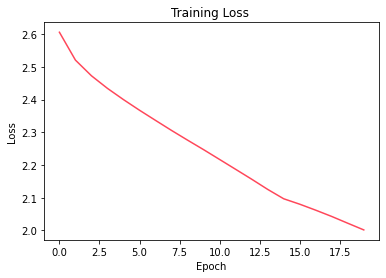

In [15]:
plot_loss_with_acc(loss, [])

In [16]:
 
# y_pred = KMeans(n_clusters=12,init='k-means++').fit_predict(feature_layer.detach().numpy())
def purity_score(y_true, y_pred):
    # compute contingency matrix (also called confusion matrix)
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    # return purity
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)

print('purity : ',purity_score(labelList[test_mask],pre_label))
print('ARI : ',adjusted_rand_score(labelList[test_mask],pre_label))
print('NMI : ',normalized_mutual_info_score(labelList[test_mask],pre_label))


purity :  0.1588235294117647
ARI :  0.0
NMI :  0.0


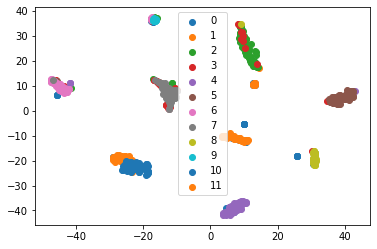

In [17]:
from sklearn.manifold import TSNE
tsne = TSNE()
out = tsne.fit_transform(test_logits)
fig = plt.figure()
for i in range(12):
    indices = test_label == i
    x, y = out[indices].T
    plt.scatter(x, y, label=str(i))
plt.legend()